# CSE 510 Reinforcement Learning Spring 2020 Assignment 3
# Policy Gradient & Actor-Critic - Part TWO (Actor-Critic)
## Srisai Karthik Neelamraju 50316785, neelamra@buffalo.edu

## Advantage Actor-Critic (A2C) algorithm for solving OpenAI CartPole

### Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
import gym
from collections import deque

### Defining the agent that implements A2C algorithm

In [2]:
class A2CAgent:
    def __init__(self, env, alpha=0.01, gamma=0.99):
        # initializing an A2C agent
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.n_input = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        self.curr_episode = []
        self.init_net()

    def init_net(self):
        class ACNetwork(nn.Module):
            def __init__(self, n_input=4, n_output=2):
                super(ACNetwork, self).__init__()
                self.l1 = nn.Linear(n_input, 10)
                self.actor = nn.Linear(10, n_output)
                self.critic = nn.Linear(10, 1)
            def forward(self, x):
                x = F.relu(self.l1(x))
                return F.softmax(self.actor(x), dim=-1), self.critic(x)

        self.pnet = ACNetwork()
        self.optimizer = Adam(self.pnet.parameters(), lr=self.alpha)

    def policy(self, state, test=False):
        state = torch.from_numpy(state).float()
        probs, _ = self.pnet(state)
        probs = probs.data.numpy()
        if test:
            return np.argmax(probs)
        return np.random.choice(self.n_actions, p=probs)

    def store_transition(self, state, action, reward, next_state, done):
        self.curr_episode.append({'state': state,
                                  'action': action,
                                  'reward': reward,
                                  'next_state': next_state,
                                  'done': done})

    def train(self):
        """
            The idea of implementing the update step in the algorithm is referenced from the PyTorch example,
            available at https://github.com/pytorch/examples/tree/master/reinforcement_learning
        """
        T = len(self.curr_episode)
        R = np.zeros(T)
        R[T - 1] = self.curr_episode[T - 1]['reward']
        for t in reversed(range(T - 1)):
            R[t] = self.curr_episode[t]['reward'] + self.gamma * R[t + 1]

        self.optimizer.zero_grad()
        for t in range(T):
            state = torch.from_numpy(self.curr_episode[t]['state']).float()
            action = torch.tensor(self.curr_episode[t]['action'])
            reward = self.curr_episode[t]['reward']
            next_state = torch.from_numpy(self.curr_episode[t]['next_state']).float()
            probs, value = self.pnet(state)
            dist = Categorical(probs)
            adv = R[t] - value.item()
            if not done:
                _, next_value = self.pnet(next_state)
                adv += self.gamma * next_value.item()
            a_loss = - dist.log_prob(action) * adv
            c_loss = torch.tensor(adv)
            loss = a_loss + c_loss
            loss.backward()
        self.optimizer.step()
        self.curr_episode = []

### Training the agent on the OpenAI CartPole environment

In [3]:
# initializing the Cartpole-v0 environment
env_cp = gym.make("CartPole-v0")

# initializing the A2C agent
a2c_agent = A2CAgent(env_cp, alpha=0.01)

scores = []
avg_scores = []
last100_avg_scores = []

episodes = 1000
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    flag = False
    score = 0
    while not done:
        action = a2c_agent.policy(state)
        next_state, reward, done, _ = env_cp.step(action)
        if done and score != 199.0:
            flag = True
            reward = 0.0
        a2c_agent.store_transition(state.copy(), action, reward, next_state.copy(), done)
        np.copyto(state, next_state)
        score += reward if not flag else 1.0
    a2c_agent.train()
    scores.append(score)
    avg_scores.append(np.mean(scores))
    last100_avg_scores.append(np.mean(scores[-100:]))
    print("Episode: " + str(episode) + ", Score: " + str(score) + ", Avg Score: " + str(avg_scores[-1]) +
          ", Avg Score (Last 100 runs): " + str(last100_avg_scores[-1]))

C:\Users\neela\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 1, Score: 15.0, Avg Score: 15.0, Avg Score (Last 100 runs): 15.0
Episode: 2, Score: 16.0, Avg Score: 15.5, Avg Score (Last 100 runs): 15.5
Episode: 3, Score: 13.0, Avg Score: 14.666666666666666, Avg Score (Last 100 runs): 14.666666666666666
Episode: 4, Score: 13.0, Avg Score: 14.25, Avg Score (Last 100 runs): 14.25
Episode: 5, Score: 18.0, Avg Score: 15.0, Avg Score (Last 100 runs): 15.0
Episode: 6, Score: 12.0, Avg Score: 14.5, Avg Score (Last 100 runs): 14.5
Episode: 7, Score: 22.0, Avg Score: 15.571428571428571, Avg Score (Last 100 runs): 15.571428571428571
Episode: 8, Score: 10.0, Avg Score: 14.875, Avg Score (Last 100 runs): 14.875
Episode: 9, Score: 23.0, Avg Score: 15.777777777777779, Avg Score (Last 100 runs): 15.777777777777779
Episode: 10, Score: 13.0, Avg Score: 15.5, Avg Score (Last 100 runs): 15.5
Episode: 11, Score: 13.0, Avg Score: 15.272727272727273, Avg Score (Last 100 runs): 15.272727272727273
Episode: 12, Score: 15.0, Avg Score: 15.25, Avg Score (Last 100 ru

Episode: 175, Score: 200.0, Avg Score: 72.31428571428572, Avg Score (Last 100 runs): 109.4
Episode: 176, Score: 200.0, Avg Score: 73.03977272727273, Avg Score (Last 100 runs): 110.96
Episode: 177, Score: 200.0, Avg Score: 73.75706214689265, Avg Score (Last 100 runs): 112.63
Episode: 178, Score: 200.0, Avg Score: 74.46629213483146, Avg Score (Last 100 runs): 114.23
Episode: 179, Score: 200.0, Avg Score: 75.16759776536313, Avg Score (Last 100 runs): 115.89
Episode: 180, Score: 200.0, Avg Score: 75.86111111111111, Avg Score (Last 100 runs): 117.74
Episode: 181, Score: 200.0, Avg Score: 76.54696132596685, Avg Score (Last 100 runs): 119.23
Episode: 182, Score: 200.0, Avg Score: 77.22527472527473, Avg Score (Last 100 runs): 120.79
Episode: 183, Score: 200.0, Avg Score: 77.89617486338798, Avg Score (Last 100 runs): 122.57
Episode: 184, Score: 200.0, Avg Score: 78.55978260869566, Avg Score (Last 100 runs): 124.24
Episode: 185, Score: 200.0, Avg Score: 79.21621621621621, Avg Score (Last 100 run

Episode: 352, Score: 200.0, Avg Score: 123.59375, Avg Score (Last 100 runs): 168.4
Episode: 353, Score: 200.0, Avg Score: 123.81019830028329, Avg Score (Last 100 runs): 170.24
Episode: 354, Score: 200.0, Avg Score: 124.02542372881356, Avg Score (Last 100 runs): 170.24
Episode: 355, Score: 200.0, Avg Score: 124.2394366197183, Avg Score (Last 100 runs): 170.24
Episode: 356, Score: 200.0, Avg Score: 124.45224719101124, Avg Score (Last 100 runs): 171.09
Episode: 357, Score: 200.0, Avg Score: 124.66386554621849, Avg Score (Last 100 runs): 171.09
Episode: 358, Score: 200.0, Avg Score: 124.87430167597765, Avg Score (Last 100 runs): 171.69
Episode: 359, Score: 200.0, Avg Score: 125.08356545961003, Avg Score (Last 100 runs): 171.69
Episode: 360, Score: 200.0, Avg Score: 125.29166666666667, Avg Score (Last 100 runs): 172.32
Episode: 361, Score: 200.0, Avg Score: 125.49861495844875, Avg Score (Last 100 runs): 172.32
Episode: 362, Score: 200.0, Avg Score: 125.70441988950276, Avg Score (Last 100 ru

Episode: 529, Score: 200.0, Avg Score: 146.3610586011342, Avg Score (Last 100 runs): 200.0
Episode: 530, Score: 200.0, Avg Score: 146.46226415094338, Avg Score (Last 100 runs): 200.0
Episode: 531, Score: 200.0, Avg Score: 146.56308851224105, Avg Score (Last 100 runs): 200.0
Episode: 532, Score: 200.0, Avg Score: 146.66353383458647, Avg Score (Last 100 runs): 200.0
Episode: 533, Score: 200.0, Avg Score: 146.76360225140712, Avg Score (Last 100 runs): 200.0
Episode: 534, Score: 200.0, Avg Score: 146.86329588014982, Avg Score (Last 100 runs): 200.0
Episode: 535, Score: 200.0, Avg Score: 146.9626168224299, Avg Score (Last 100 runs): 200.0
Episode: 536, Score: 200.0, Avg Score: 147.0615671641791, Avg Score (Last 100 runs): 200.0
Episode: 537, Score: 200.0, Avg Score: 147.16014897579143, Avg Score (Last 100 runs): 200.0
Episode: 538, Score: 200.0, Avg Score: 147.25836431226764, Avg Score (Last 100 runs): 200.0
Episode: 539, Score: 200.0, Avg Score: 147.35621521335807, Avg Score (Last 100 runs

Episode: 707, Score: 200.0, Avg Score: 159.86562942008487, Avg Score (Last 100 runs): 200.0
Episode: 708, Score: 200.0, Avg Score: 159.9223163841808, Avg Score (Last 100 runs): 200.0
Episode: 709, Score: 200.0, Avg Score: 159.97884344146686, Avg Score (Last 100 runs): 200.0
Episode: 710, Score: 200.0, Avg Score: 160.03521126760563, Avg Score (Last 100 runs): 200.0
Episode: 711, Score: 200.0, Avg Score: 160.0914205344585, Avg Score (Last 100 runs): 200.0
Episode: 712, Score: 200.0, Avg Score: 160.14747191011236, Avg Score (Last 100 runs): 200.0
Episode: 713, Score: 200.0, Avg Score: 160.20336605890603, Avg Score (Last 100 runs): 200.0
Episode: 714, Score: 200.0, Avg Score: 160.2591036414566, Avg Score (Last 100 runs): 200.0
Episode: 715, Score: 200.0, Avg Score: 160.3146853146853, Avg Score (Last 100 runs): 200.0
Episode: 716, Score: 200.0, Avg Score: 160.37011173184356, Avg Score (Last 100 runs): 200.0
Episode: 717, Score: 200.0, Avg Score: 160.42538354253836, Avg Score (Last 100 runs)

Episode: 885, Score: 200.0, Avg Score: 167.93785310734464, Avg Score (Last 100 runs): 200.0
Episode: 886, Score: 200.0, Avg Score: 167.97404063205417, Avg Score (Last 100 runs): 200.0
Episode: 887, Score: 200.0, Avg Score: 168.01014656144307, Avg Score (Last 100 runs): 200.0
Episode: 888, Score: 200.0, Avg Score: 168.04617117117118, Avg Score (Last 100 runs): 200.0
Episode: 889, Score: 200.0, Avg Score: 168.08211473565805, Avg Score (Last 100 runs): 200.0
Episode: 890, Score: 200.0, Avg Score: 168.11797752808988, Avg Score (Last 100 runs): 200.0
Episode: 891, Score: 200.0, Avg Score: 168.1537598204265, Avg Score (Last 100 runs): 200.0
Episode: 892, Score: 200.0, Avg Score: 168.1894618834081, Avg Score (Last 100 runs): 200.0
Episode: 893, Score: 200.0, Avg Score: 168.22508398656214, Avg Score (Last 100 runs): 200.0
Episode: 894, Score: 200.0, Avg Score: 168.2606263982103, Avg Score (Last 100 runs): 200.0
Episode: 895, Score: 200.0, Avg Score: 168.29608938547486, Avg Score (Last 100 runs

### Visualizing the scores while training the agent

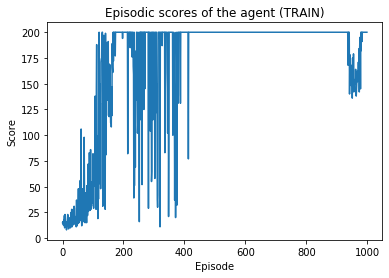

In [4]:
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episodic scores of the agent (TRAIN)')
plt.plot(scores)
plt.show()

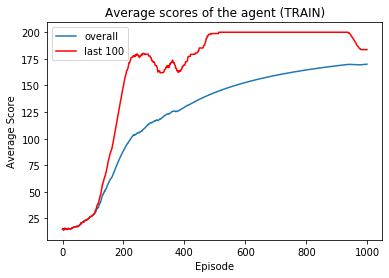

In [5]:
plt.plot(avg_scores, label='overall')
plt.plot(last100_avg_scores, color='red', label='last 100')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Average scores of the agent (TRAIN)')
plt.legend(loc='upper left')
plt.show()

### Observing performance of the trained agent for 100 episodes

In [6]:
test_scores = []

print("Testing the performance of the trained TD Actor-Critic agent\n")

episodes = 100
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = a2c_agent.policy(state, test=True)
        next_state, reward, done, _ = env_cp.step(action)
        np.copyto(state, next_state)
        score += reward
    test_scores.append(score)
    print("Episode: " + str(episode) + ", Score: " + str(score))

print("Avg Score over 100 test episodes: " + str(np.mean(test_scores)))

Testing the performance of the trained TD Actor-Critic agent

Episode: 1, Score: 200.0
Episode: 2, Score: 200.0
Episode: 3, Score: 200.0
Episode: 4, Score: 200.0
Episode: 5, Score: 200.0
Episode: 6, Score: 200.0
Episode: 7, Score: 200.0
Episode: 8, Score: 200.0
Episode: 9, Score: 200.0
Episode: 10, Score: 200.0
Episode: 11, Score: 200.0
Episode: 12, Score: 200.0
Episode: 13, Score: 200.0
Episode: 14, Score: 200.0
Episode: 15, Score: 200.0
Episode: 16, Score: 200.0
Episode: 17, Score: 200.0
Episode: 18, Score: 200.0
Episode: 19, Score: 200.0
Episode: 20, Score: 200.0
Episode: 21, Score: 200.0
Episode: 22, Score: 200.0
Episode: 23, Score: 200.0
Episode: 24, Score: 200.0
Episode: 25, Score: 200.0
Episode: 26, Score: 200.0
Episode: 27, Score: 200.0
Episode: 28, Score: 200.0
Episode: 29, Score: 200.0
Episode: 30, Score: 200.0
Episode: 31, Score: 200.0
Episode: 32, Score: 200.0
Episode: 33, Score: 200.0
Episode: 34, Score: 200.0
Episode: 35, Score: 200.0
Episode: 36, Score: 200.0
Episode: 37

### Visualizing the average scores while testing the agent

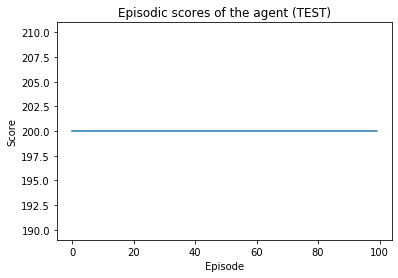

In [7]:
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episodic scores of the agent (TEST)')
plt.plot(test_scores)
plt.show()